In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lal
from pycbc.types.timeseries import TimeSeries
from pycbc import frame
from pycbc.psd import welch
from tqdm import tqdm

### 1. ETD detector noise ASD.

In [5]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
path_det_ETD_noise = "/mnt/d/project_data/psd_3g/data/ET-D/ETD_6h/det_noise_ET-D_21600s.gwf"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list = []

for i in tqdm(range(int((21600-3600)/stride))):
    det_noise = frame.read_frame(location=path_det_ETD_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    delta_t = 1.0/det_noise.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_det = welch(det_noise.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    psd_list.append(estimated_psd_det.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list = np.array(psd_list)
print(psd_list)
print(np.shape(psd_list))

name_keys = {'frequency': np.array(estimated_psd_det.sample_frequencies).T}
for i in range(len(psd_list)):
    name_keys['psd_%s' % i] = psd_list[i]
det_psd_file = pd.DataFrame(name_keys)
det_psd_file.to_csv("./psd_ETD_det_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [32:19<00:57, 57.03s/it]


[[4.90123257e-55 1.02844224e-54 1.16138456e-54 ... 8.19345205e-49
  9.53514466e-49 1.88146864e-49]
 [7.36765007e-55 1.54281870e-54 1.68217006e-54 ... 1.39753028e-48
  1.35109527e-48 4.03218865e-49]
 [6.58021535e-55 1.34421587e-54 1.44474165e-54 ... 1.24001481e-48
  1.60332214e-48 3.13484539e-49]
 ...
 [6.59015279e-55 1.35445381e-54 1.47907148e-54 ... 1.60170318e-48
  1.26438004e-48 2.41210744e-49]
 [3.13918476e-55 6.56883845e-55 8.15948872e-55 ... 1.25067563e-48
  1.17737431e-48 5.29986182e-49]
 [4.63983398e-55 9.38249924e-55 1.01048378e-54 ... 1.45984639e-48
  1.48644763e-48 4.32058500e-49]]
(35, 32769)


In [6]:
median_psd = np.median(psd_list, axis=0)
print(median_psd)

max_psd = np.max(psd_list, axis=0)
print(max_psd)

min_psd = np.min(psd_list, axis=0)
print(min_psd)

[6.55708419e-55 1.34421587e-54 1.47907148e-54 ... 1.35345744e-48
 1.25445908e-48 3.71389514e-49]
[1.47852402e-54 2.99921818e-54 3.12835760e-54 ... 2.05618645e-48
 1.90917757e-48 6.86086741e-49]
[2.74781139e-55 5.60840123e-55 8.15948872e-55 ... 6.70076802e-49
 7.61479535e-49 1.88146864e-49]


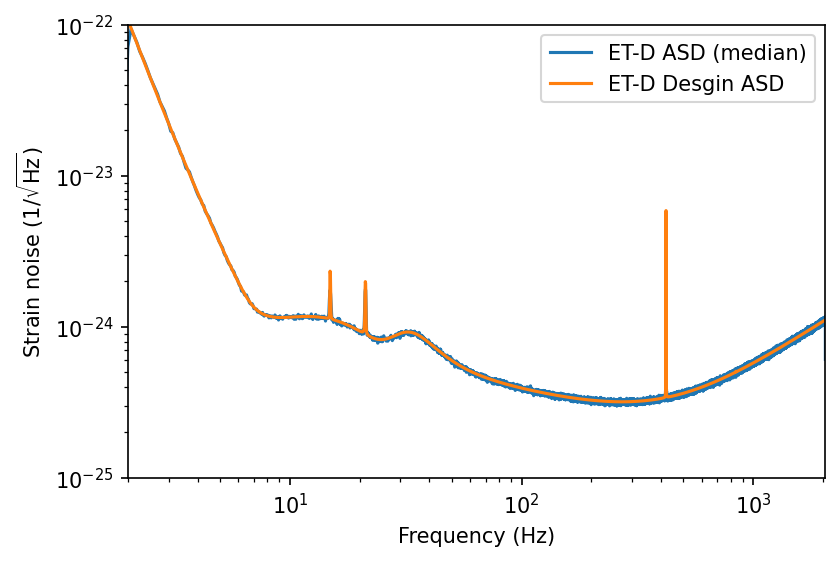

In [8]:
plt.figure(dpi=150)

# plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(estimated_psd_det), label="ET-D ASD")
plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(median_psd), label="ET-D ASD (median)")

plt.loglog(asd_ETD[0], asd_ETD[1], label="ET-D Desgin ASD")
plt.xlim(2, det_noise.sample_rate/2)
plt.ylim(10**(-25), 10**(-22))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

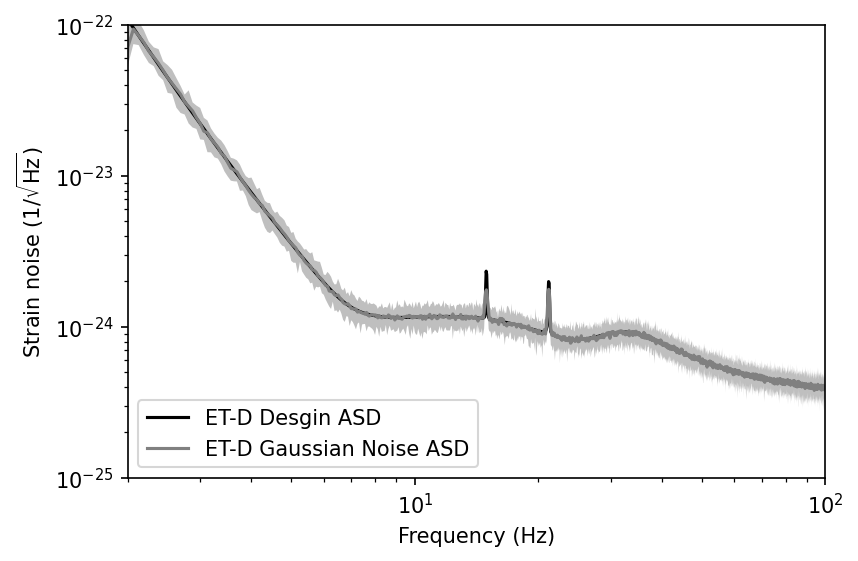

In [11]:
plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
# plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(estimated_psd_det), label="ET-D ASD")
plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(median_psd), color="gray", label="ET-D Gaussian Noise ASD")
plt.fill_between(estimated_psd_det.sample_frequencies, np.sqrt(min_psd), np.sqrt(max_psd), alpha=.5, linewidth=0, color="gray")

plt.xlim(2, 100)
plt.ylim(10**(-25), 10**(-22))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

### 2. ETD total noise ASD (median R0).

In [12]:
# median local merger rate

path_bbh_ETD_median = "/mnt/d/project_data/psd_3g/data/ET-D/bbh_median_ETD_norotation_6h/confusion_noise_ET-D_1_BBH_21600s.gwf"
path_bns_ETD_median = "/mnt/d/project_data/psd_3g/data/ET-D/bns_median_ETD_norotation_6h/confusion_noise_ET-D_1_BNS_21600s.gwf"
path_nsbh_ETD_median = "/mnt/d/project_data/psd_3g/data/ET-D/nsbh_median_ETD_norotation_6h/confusion_noise_ET-D_1_NSBH_21600s.gwf"
path_det_ETD_noise = "/mnt/d/project_data/psd_3g/data/ET-D/ETD_6h/det_noise_ET-D_21600s.gwf"

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list_bbh_ETD_median = []
psd_list_bns_ETD_median = []
psd_list_nsbh_ETD_median = []
psd_list_total_median = []

for i in tqdm(range(int((21600-3600)/stride))):
    bbh_ETD_median = frame.read_frame(location=path_bbh_ETD_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    bns_ETD_median = frame.read_frame(location=path_bns_ETD_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    nsbh_ETD_median = frame.read_frame(location=path_nsbh_ETD_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    det_noise = frame.read_frame(location=path_det_ETD_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    total_noise = bbh_ETD_median.data + bns_ETD_median.data + nsbh_ETD_median.data + det_noise.data
    epoch = lal.LIGOTimeGPS(det_noise.start_time)
    total_noise = TimeSeries(total_noise, delta_t=1.0/det_noise.sample_rate, epoch=epoch)
    delta_t = 1.0/bbh_ETD_median.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_bbh_ETD_median = welch(bbh_ETD_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_bns_ETD_median = welch(bns_ETD_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_nsbh_ETD_median = welch(nsbh_ETD_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_total_median = welch(total_noise, seg_len=seg_len, seg_stride=seg_stride)
    psd_list_bbh_ETD_median.append(estimated_psd_bbh_ETD_median.data)
    psd_list_bns_ETD_median.append(estimated_psd_bns_ETD_median.data)
    psd_list_nsbh_ETD_median.append(estimated_psd_nsbh_ETD_median.data)
    psd_list_total_median.append(estimated_psd_total_median.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list_bbh_ETD_median = np.array(psd_list_bbh_ETD_median)
psd_list_bns_ETD_median = np.array(psd_list_bns_ETD_median)
psd_list_nsbh_ETD_median = np.array(psd_list_nsbh_ETD_median)
psd_list_total_median = np.array(psd_list_total_median)

# save bbh case
print(psd_list_bbh_ETD_median)
print(np.shape(psd_list_bbh_ETD_median))

name_keys = {'frequency': np.array(estimated_psd_bbh_ETD_median.sample_frequencies).T}
for i in range(len(psd_list_bbh_ETD_median)):
    name_keys['psd_%s' % i] = psd_list_bbh_ETD_median[i]
bbh_ETD_median_psd_file = pd.DataFrame(name_keys)
bbh_ETD_median_psd_file.to_csv("./psd_bbh_ETD_median_512s_16s_5h.csv", index=False, sep=',')

# save bns case
print(psd_list_bns_ETD_median)
print(np.shape(psd_list_bns_ETD_median))

name_keys = {'frequency': np.array(estimated_psd_bns_ETD_median.sample_frequencies).T}
for i in range(len(psd_list_bns_ETD_median)):
    name_keys['psd_%s' % i] = psd_list_bns_ETD_median[i]
bns_ETD_median_psd_file = pd.DataFrame(name_keys)
bns_ETD_median_psd_file.to_csv("./psd_bns_ETD_median_512s_16s_5h.csv", index=False, sep=',')

# save nsbh case
print(psd_list_nsbh_ETD_median)
print(np.shape(psd_list_nsbh_ETD_median))

name_keys = {'frequency': np.array(estimated_psd_nsbh_ETD_median.sample_frequencies).T}
for i in range(len(psd_list_nsbh_ETD_median)):
    name_keys['psd_%s' % i] = psd_list_nsbh_ETD_median[i]
nsbh_ETD_median_psd_file = pd.DataFrame(name_keys)
nsbh_ETD_median_psd_file.to_csv("./psd_nsbh_ETD_median_512s_16s_5h.csv", index=False, sep=',')

# save total case
print(psd_list_total_median)
print(np.shape(psd_list_total_median))

name_keys = {'frequency': np.array(estimated_psd_total_median.sample_frequencies).T}
for i in range(len(psd_list_total_median)):
    name_keys['psd_%s' % i] = psd_list_total_median[i]
total_ETD_median_psd_file = pd.DataFrame(name_keys)
total_ETD_median_psd_file.to_csv("./psd_total_ETD_median_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [1:50:38<03:15, 195.26s/it]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(35, 32769)
[[7.90750559e-62 1.58554961e-61 1.66135371e-61 ... 2.05146701e-60
  1.46554114e-57 2.67219619e-57]
 [7.94073187e-62 1.52134079e-61 1.59330355e-61 ... 6.58541334e-59
  2.30273245e-57 4.66192940e-57]
 [1.02124761e-61 2.32040218e-61 2.29788995e-61 ... 2.50900286e-58
  8.07554293e-57 1.19739136e-56]
 ...
 [3.21447839e-62 4.94311391e-62 6.44025835e-62 ... 4.45593886e-61
  5.85400581e-58 1.17201559e-57]
 [2.42253468e-62 6.39778085e-62 5.37457987e-62 ... 4.97425926e-62
  1.49360137e-58 2.61035717e-58]
 [6.12586143e-63 1.22627769e-62 9.96608393e-63 ... 2.31684346e-62
  4.51019702e-59 6.45444943e-59]]
(35, 32769)
[[5.20991228e-58 1.51238465e-57 1.36026671e-57 ... 2.05552177e-72
  1.85022402e-72 7.40442482e-73]
 [3.73361684e-58 6.39989450e-58 6.59357171e-58 ... 1.96661066e-67
  1.25446785e-67 3.07732566e-68]
 [1.45089150e-57 2.970

In [13]:
median_psd_total_median = np.median(psd_list_total_median, axis=0)
print(median_psd_total_median)

max_psd_total_median = np.max(psd_list_total_median, axis=0)
print(max_psd_total_median)

min_psd_total_median = np.min(psd_list_total_median, axis=0)
print(min_psd_total_median)

[9.81221917e-55 2.06727187e-54 2.35528783e-54 ... 1.35360734e-48
 1.25441503e-48 3.71404469e-49]
[2.12158958e-54 3.73522538e-54 4.17501411e-54 ... 2.05615406e-48
 1.90896254e-48 6.85505555e-49]
[3.21539446e-55 6.65604930e-55 8.07425832e-55 ... 6.70438902e-49
 7.61485256e-49 1.88200524e-49]


In [4]:
# load det
psd_ETD_det = pd.read_csv('psd_ETD_det_512s_16s_5h.csv')
psd_ETD_det = np.array(psd_ETD_det).T
# print(psd_ETD_det[1:])
# print(np.shape(psd_ETD_det[1:]))

mean_psd_ETD_det = np.mean(psd_ETD_det[1:], axis=0)
print(mean_psd_ETD_det)

onesigma_right_psd_ETD_det = np.percentile(a=psd_ETD_det[1:], q=84.15, axis=0)
print(onesigma_right_psd_ETD_det)

onesigma_left_psd_ETD_det = np.percentile(a=psd_ETD_det[1:], q=15.85, axis=0)
print(onesigma_left_psd_ETD_det)

# load bbh
psd_ETD_bbh_median = pd.read_csv('psd_bbh_ETD_median_512s_16s_5h.csv')
psd_ETD_bbh_median = np.array(psd_ETD_bbh_median).T

mean_psd_ETD_bbh_median = np.mean(psd_ETD_bbh_median[1:], axis=0)
onesigma_right_psd_ETD_bbh_median = np.percentile(a=psd_ETD_bbh_median[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_bbh_median = np.percentile(a=psd_ETD_bbh_median[1:], q=15.85, axis=0)

# load bns
psd_ETD_bns_median = pd.read_csv('psd_bns_ETD_median_512s_16s_5h.csv')
psd_ETD_bns_median = np.array(psd_ETD_bns_median).T

mean_psd_ETD_bns_median = np.mean(psd_ETD_bns_median[1:], axis=0)
onesigma_right_psd_ETD_bns_median = np.percentile(a=psd_ETD_bns_median[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_bns_median = np.percentile(a=psd_ETD_bns_median[1:], q=15.85, axis=0)

# load nsbh
psd_ETD_nsbh_median = pd.read_csv('psd_nsbh_ETD_median_512s_16s_5h.csv')
psd_ETD_nsbh_median = np.array(psd_ETD_nsbh_median).T

mean_psd_ETD_nsbh_median = np.mean(psd_ETD_nsbh_median[1:], axis=0)
onesigma_right_psd_ETD_nsbh_median = np.percentile(a=psd_ETD_nsbh_median[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_nsbh_median = np.percentile(a=psd_ETD_nsbh_median[1:], q=15.85, axis=0)

# load total
psd_ETD_total_median = pd.read_csv('psd_total_ETD_median_512s_16s_5h.csv')
psd_ETD_total_median = np.array(psd_ETD_total_median).T

mean_psd_ETD_total_median = np.mean(psd_ETD_total_median[1:], axis=0)
onesigma_right_psd_ETD_total_median = np.percentile(a=psd_ETD_total_median[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_total_median = np.percentile(a=psd_ETD_total_median[1:], q=15.85, axis=0)

[6.42370388e-55 1.32040372e-54 1.45520665e-54 ... 1.31289180e-48
 1.27466003e-48 3.79991271e-49]
[8.01295576e-55 1.64510518e-54 1.79499309e-54 ... 1.53302368e-48
 1.50127776e-48 4.65153099e-49]
[4.36370456e-55 8.97497282e-55 1.01256769e-54 ... 1.09187814e-48
 1.02793648e-48 2.68560525e-49]


In [4]:
print(psd_ETD_total_median[0])

[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03]


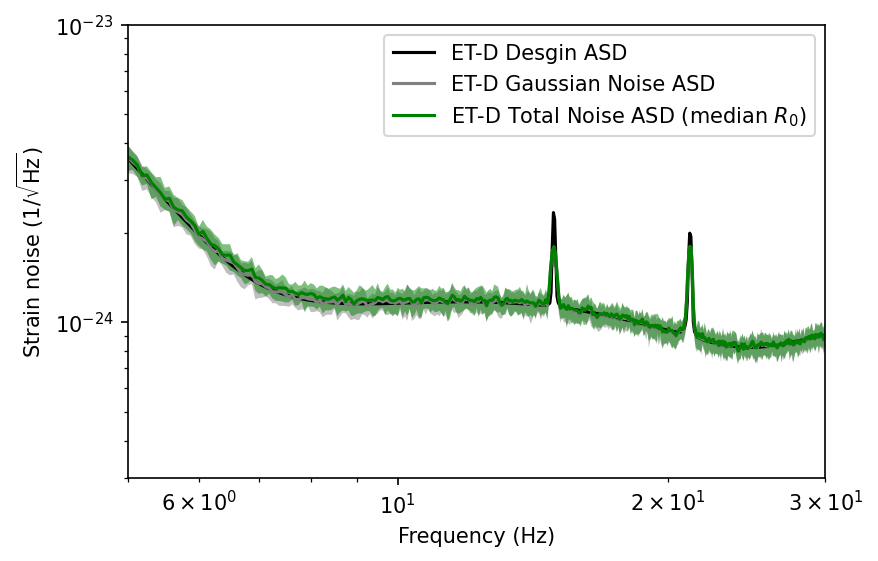

In [5]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="gray", label="ET-D Gaussian Noise ASD")
plt.fill_between(psd_ETD_det[0], np.sqrt(onesigma_left_psd_ETD_det), np.sqrt(onesigma_right_psd_ETD_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_ETD_total_median[0], np.sqrt(mean_psd_ETD_total_median), color="green", label=r"ET-D Total Noise ASD (median $R_{0}$)")
plt.fill_between(psd_ETD_total_median[0], np.sqrt(onesigma_left_psd_ETD_total_median), np.sqrt(onesigma_right_psd_ETD_total_median), alpha=.5, linewidth=0, color="green")

plt.xlim(5, 30)
plt.ylim(3*10**(-25), 1*10**(-23))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

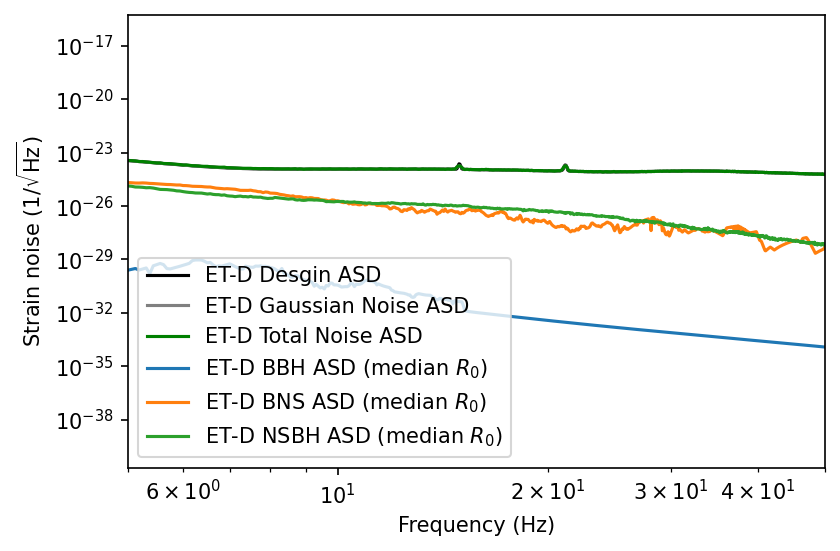

In [5]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="gray", label="ET-D Gaussian Noise ASD")
# plt.fill_between(psd_ETD_det[0], np.sqrt(min_psd_ETD_det), np.sqrt(max_psd_ETD_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_ETD_total_median[0], np.sqrt(mean_psd_ETD_total_median), color="green", label="ET-D Total Noise ASD")
# plt.fill_between(estimated_psd_total_median.sample_frequencies, np.sqrt(min_psd_total_median), np.sqrt(max_psd_total_median), alpha=.5, linewidth=0, color="green")

plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_bbh_median), label=r"ET-D BBH ASD (median $R_{0}$)")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_bns_median), label=r"ET-D BNS ASD (median $R_{0}$)")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_nsbh_median), label=r"ET-D NSBH ASD (median $R_{0}$)")


plt.xlim(5, 50)
# plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

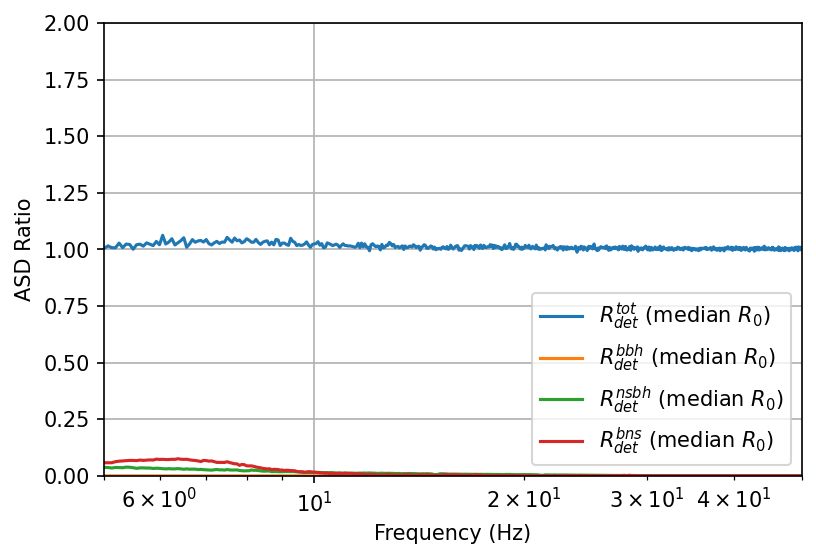

In [6]:
ratio_tot_guassian = np.sqrt(mean_psd_ETD_total_median) / np.sqrt(mean_psd_ETD_det)
ratio_bbh_guassian = np.sqrt(mean_psd_ETD_bbh_median) / np.sqrt(mean_psd_ETD_det)
ratio_bns_guassian = np.sqrt(mean_psd_ETD_bns_median) / np.sqrt(mean_psd_ETD_det)
ratio_nsbh_guassian = np.sqrt(mean_psd_ETD_nsbh_median) / np.sqrt(mean_psd_ETD_det)

plt.figure(dpi=150)
plt.semilogx(psd_ETD_det[0], ratio_tot_guassian, label=r"$R_{det}^{tot}$ (median $R_{0}$)")
plt.semilogx(psd_ETD_det[0], ratio_bbh_guassian, label=r"$R_{det}^{bbh}$ (median $R_{0}$)")
plt.semilogx(psd_ETD_det[0], ratio_nsbh_guassian, label=r"$R_{det}^{nsbh}$ (median $R_{0}$)")
plt.semilogx(psd_ETD_det[0], ratio_bns_guassian, label=r"$R_{det}^{bns}$ (median $R_{0}$)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("ASD Ratio")
plt.xlim(5, 50)
plt.ylim(0, 2)
plt.legend(loc='lower right')
plt.grid()
plt.show()


### 3. ETD total noise ASD (upper R0).

In [32]:
# upper local merger rate

path_bbh_ETD_upper = "/mnt/d/project_data/psd_3g/data/ET-D/bbh_upper_ETD_norotation_6h/confusion_noise_ET-D_1_BBH_21600s.gwf"
path_bns_ETD_upper = "/mnt/d/project_data/psd_3g/data/ET-D/bns_upper_ETD_norotation_6h/confusion_noise_ET-D_1_BNS_21600s.gwf"
path_nsbh_ETD_upper = "/mnt/d/project_data/psd_3g/data/ET-D/nsbh_upper_ETD_norotation_6h/confusion_noise_ET-D_1_NSBH_21600s.gwf"
path_det_ETD_noise = "/mnt/d/project_data/psd_3g/data/ET-D/ETD_6h/det_noise_ET-D_21600s.gwf"

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list_bbh_ETD_upper = []
psd_list_bns_ETD_upper = []
psd_list_nsbh_ETD_upper = []
psd_list_total_upper = []

for i in tqdm(range(int((21600-3600)/stride))):
    bbh_ETD_upper = frame.read_frame(location=path_bbh_ETD_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    bns_ETD_upper = frame.read_frame(location=path_bns_ETD_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    nsbh_ETD_upper = frame.read_frame(location=path_nsbh_ETD_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    det_noise = frame.read_frame(location=path_det_ETD_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    total_noise = bbh_ETD_upper.data + bns_ETD_upper.data + nsbh_ETD_upper.data + det_noise.data
    epoch = lal.LIGOTimeGPS(det_noise.start_time)
    total_noise = TimeSeries(total_noise, delta_t=1.0/det_noise.sample_rate, epoch=epoch)
    delta_t = 1.0/bbh_ETD_upper.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_bbh_ETD_upper = welch(bbh_ETD_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_bns_ETD_upper = welch(bns_ETD_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_nsbh_ETD_upper = welch(nsbh_ETD_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_total_upper = welch(total_noise, seg_len=seg_len, seg_stride=seg_stride)
    psd_list_bbh_ETD_upper.append(estimated_psd_bbh_ETD_upper.data)
    psd_list_bns_ETD_upper.append(estimated_psd_bns_ETD_upper.data)
    psd_list_nsbh_ETD_upper.append(estimated_psd_nsbh_ETD_upper.data)
    psd_list_total_upper.append(estimated_psd_total_upper.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list_bbh_ETD_upper = np.array(psd_list_bbh_ETD_upper)
psd_list_bns_ETD_upper = np.array(psd_list_bns_ETD_upper)
psd_list_nsbh_ETD_upper = np.array(psd_list_nsbh_ETD_upper)
psd_list_total_upper = np.array(psd_list_total_upper)

# save bbh case
print(psd_list_bbh_ETD_upper)
print(np.shape(psd_list_bbh_ETD_upper))

name_keys = {'frequency': np.array(estimated_psd_bbh_ETD_upper.sample_frequencies).T}
for i in range(len(psd_list_bbh_ETD_upper)):
    name_keys['psd_%s' % i] = psd_list_bbh_ETD_upper[i]
bbh_ETD_upper_psd_file = pd.DataFrame(name_keys)
bbh_ETD_upper_psd_file.to_csv("./psd_bbh_ETD_upper_512s_16s_5h.csv", index=False, sep=',')

# save bns case
print(psd_list_bns_ETD_upper)
print(np.shape(psd_list_bns_ETD_upper))

name_keys = {'frequency': np.array(estimated_psd_bns_ETD_upper.sample_frequencies).T}
for i in range(len(psd_list_bns_ETD_upper)):
    name_keys['psd_%s' % i] = psd_list_bns_ETD_upper[i]
bns_ETD_upper_psd_file = pd.DataFrame(name_keys)
bns_ETD_upper_psd_file.to_csv("./psd_bns_ETD_upper_512s_16s_5h.csv", index=False, sep=',')

# save nsbh case
print(psd_list_nsbh_ETD_upper)
print(np.shape(psd_list_nsbh_ETD_upper))

name_keys = {'frequency': np.array(estimated_psd_nsbh_ETD_upper.sample_frequencies).T}
for i in range(len(psd_list_nsbh_ETD_upper)):
    name_keys['psd_%s' % i] = psd_list_nsbh_ETD_upper[i]
nsbh_ETD_upper_psd_file = pd.DataFrame(name_keys)
nsbh_ETD_upper_psd_file.to_csv("./psd_nsbh_ETD_upper_512s_16s_5h.csv", index=False, sep=',')

# save total case
print(psd_list_total_upper)
print(np.shape(psd_list_total_upper))

name_keys = {'frequency': np.array(estimated_psd_total_upper.sample_frequencies).T}
for i in range(len(psd_list_total_upper)):
    name_keys['psd_%s' % i] = psd_list_total_upper[i]
total_ETD_upper_psd_file = pd.DataFrame(name_keys)
total_ETD_upper_psd_file.to_csv("./psd_total_ETD_upper_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [1:54:05<03:21, 201.34s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.09589836e-63 1.42574218e-62 1.44547406e-62 ... 3.86582118e-77
  3.22887652e-77 5.75239964e-78]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.64790224e-62 9.31485051e-62 9.37172806e-62 ... 2.15595934e-76
  1.34374588e-76 3.43839973e-77]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(35, 32769)
[[5.97967995e-61 1.23040075e-60 1.32479157e-60 ... 5.44564701e-56
  9.80323741e-56 5.49623067e-56]
 [9.47278466e-61 1.93281429e-60 1.89357113e-60 ... 1.06530881e-55
  1.74500951e-55 1.55446884e-55]
 [3.86040111e-61 8.28187836e-61 8.37067063e-61 ... 1.08614175e-55
  1.98133473e-55 4.48334960e-56]
 ...
 [2.48571313e-61 5.61270801e-61 5.18730103e-61 ... 4.81470521e-56
  4.97205070e-56 1.9

In [7]:
# load det
psd_ETD_det = pd.read_csv('psd_ETD_det_512s_16s_5h.csv')
psd_ETD_det = np.array(psd_ETD_det).T
# print(psd_ETD_det[1:])
# print(np.shape(psd_ETD_det[1:]))

mean_psd_ETD_det = np.mean(psd_ETD_det[1:], axis=0)
print(mean_psd_ETD_det)

onesigma_right_psd_ETD_det = np.percentile(a=psd_ETD_det[1:], q=84.15, axis=0)
print(onesigma_right_psd_ETD_det)

onesigma_left_psd_ETD_det = np.percentile(a=psd_ETD_det[1:], q=15.85, axis=0)
print(onesigma_left_psd_ETD_det)

# load bbh
psd_ETD_bbh_upper = pd.read_csv('psd_bbh_ETD_upper_512s_16s_5h.csv')
psd_ETD_bbh_upper = np.array(psd_ETD_bbh_upper).T

mean_psd_ETD_bbh_upper = np.mean(psd_ETD_bbh_upper[1:], axis=0)
onesigma_right_psd_ETD_bbh_upper = np.percentile(a=psd_ETD_bbh_upper[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_bbh_upper = np.percentile(a=psd_ETD_bbh_upper[1:], q=15.85, axis=0)

# load bns
psd_ETD_bns_upper = pd.read_csv('psd_bns_ETD_upper_512s_16s_5h.csv')
psd_ETD_bns_upper = np.array(psd_ETD_bns_upper).T

mean_psd_ETD_bns_upper = np.mean(psd_ETD_bns_upper[1:], axis=0)
onesigma_right_psd_ETD_bns_upper = np.percentile(a=psd_ETD_bns_upper[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_bns_upper = np.percentile(a=psd_ETD_bns_upper[1:], q=15.85, axis=0)

# load nsbh
psd_ETD_nsbh_upper = pd.read_csv('psd_nsbh_ETD_upper_512s_16s_5h.csv')
psd_ETD_nsbh_upper = np.array(psd_ETD_nsbh_upper).T

mean_psd_ETD_nsbh_upper = np.mean(psd_ETD_nsbh_upper[1:], axis=0)
onesigma_right_psd_ETD_nsbh_upper = np.percentile(a=psd_ETD_nsbh_upper[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_nsbh_upper = np.percentile(a=psd_ETD_nsbh_upper[1:], q=15.85, axis=0)

# load total
psd_ETD_total_upper = pd.read_csv('psd_total_ETD_upper_512s_16s_5h.csv')
psd_ETD_total_upper = np.array(psd_ETD_total_upper).T

mean_psd_ETD_total_upper = np.mean(psd_ETD_total_upper[1:], axis=0)
onesigma_right_psd_ETD_total_upper = np.percentile(a=psd_ETD_total_upper[1:], q=84.15, axis=0)
onesigma_left_psd_ETD_total_upper = np.percentile(a=psd_ETD_total_upper[1:], q=15.85, axis=0)

[6.42370388e-55 1.32040372e-54 1.45520665e-54 ... 1.31289180e-48
 1.27466003e-48 3.79991271e-49]
[8.01295576e-55 1.64510518e-54 1.79499309e-54 ... 1.53302368e-48
 1.50127776e-48 4.65153099e-49]
[4.36370456e-55 8.97497282e-55 1.01256769e-54 ... 1.09187814e-48
 1.02793648e-48 2.68560525e-49]


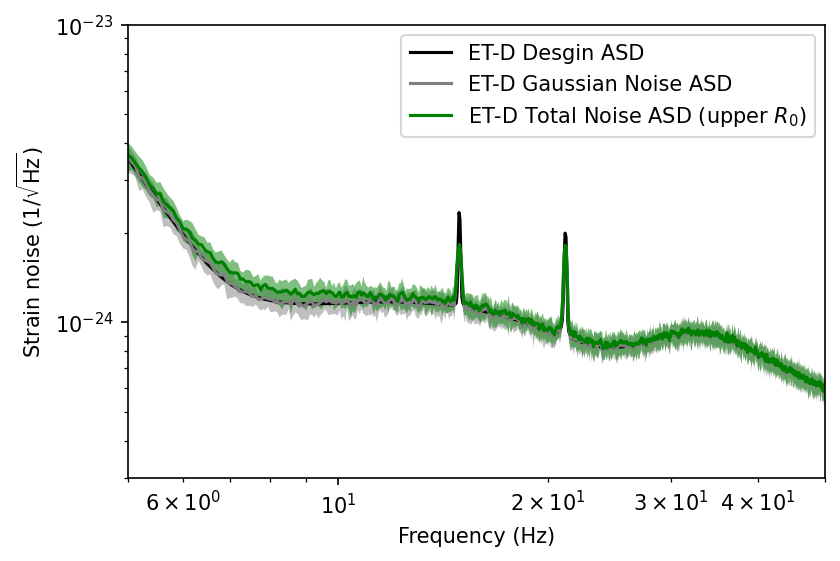

In [8]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="gray", label="ET-D Gaussian Noise ASD")
plt.fill_between(psd_ETD_det[0], np.sqrt(onesigma_left_psd_ETD_det), np.sqrt(onesigma_right_psd_ETD_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_ETD_total_upper[0], np.sqrt(mean_psd_ETD_total_upper), color="green", label=r"ET-D Total Noise ASD (upper $R_{0}$)")
plt.fill_between(psd_ETD_total_upper[0], np.sqrt(onesigma_left_psd_ETD_total_upper), np.sqrt(onesigma_right_psd_ETD_total_upper), alpha=.5, linewidth=0, color="green")

plt.xlim(5, 50)
plt.ylim(3*10**(-25), 1*10**(-23))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

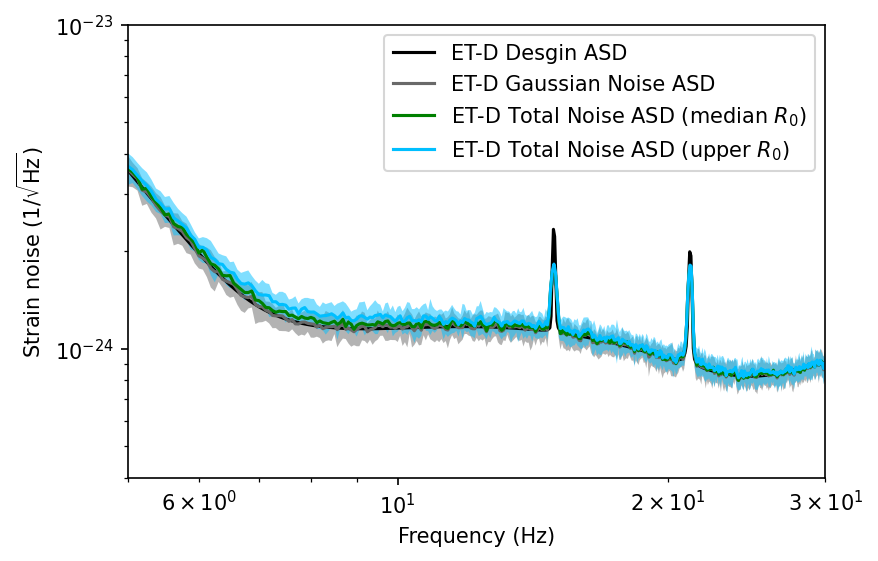

In [9]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="dimgray", label="ET-D Gaussian Noise ASD")
plt.fill_between(psd_ETD_det[0], np.sqrt(onesigma_left_psd_ETD_det), np.sqrt(onesigma_right_psd_ETD_det), alpha=.5, linewidth=0, color="dimgray")
plt.loglog(psd_ETD_total_median[0], np.sqrt(mean_psd_ETD_total_median), color="green", label=r"ET-D Total Noise ASD (median $R_{0}$)")
plt.loglog(psd_ETD_total_upper[0], np.sqrt(mean_psd_ETD_total_upper), color="deepskyblue", label=r"ET-D Total Noise ASD (upper $R_{0}$)")
plt.fill_between(psd_ETD_total_upper[0], np.sqrt(onesigma_left_psd_ETD_total_upper), np.sqrt(onesigma_right_psd_ETD_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

plt.xlim(5, 30)
plt.ylim(4*10**(-25), 1*10**(-23))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.savefig('asd_ETD_bias.pdf', dpi=500)
plt.show()

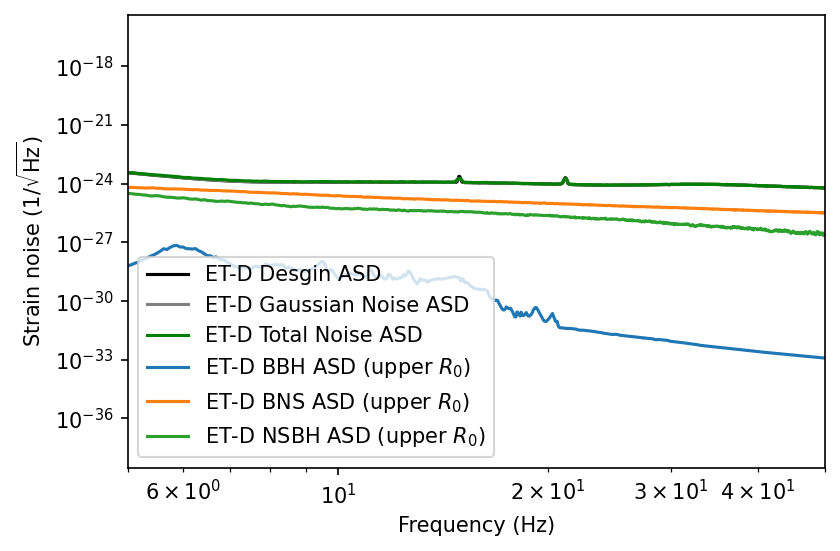

In [7]:
path_ETD_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
asd_ETD = np.loadtxt(path_ETD_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET-D Desgin ASD")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="gray", label="ET-D Gaussian Noise ASD")
plt.loglog(psd_ETD_total_upper[0], np.sqrt(mean_psd_ETD_total_upper), color="green", label="ET-D Total Noise ASD")

plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_bbh_upper), label=r"ET-D BBH ASD (upper $R_{0}$)")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_bns_upper), label=r"ET-D BNS ASD (upper $R_{0}$)")
plt.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_nsbh_upper), label=r"ET-D NSBH ASD (upper $R_{0}$)")

plt.xlim(5, 50)
# plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

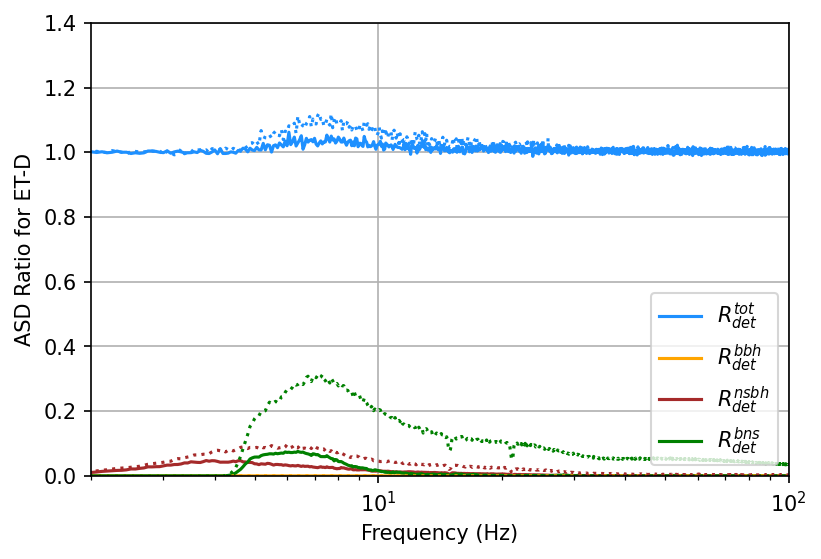

In [8]:
ratio_tot_guassian_median = np.sqrt(mean_psd_ETD_total_median) / np.sqrt(mean_psd_ETD_det)
ratio_bbh_guassian_median = np.sqrt(mean_psd_ETD_bbh_median) / np.sqrt(mean_psd_ETD_det)
ratio_bns_guassian_median = np.sqrt(mean_psd_ETD_bns_median) / np.sqrt(mean_psd_ETD_det)
ratio_nsbh_guassian_median = np.sqrt(mean_psd_ETD_nsbh_median) / np.sqrt(mean_psd_ETD_det)

ratio_tot_guassian_upper = np.sqrt(mean_psd_ETD_total_upper) / np.sqrt(mean_psd_ETD_det)
ratio_bbh_guassian_upper = np.sqrt(mean_psd_ETD_bbh_upper) / np.sqrt(mean_psd_ETD_det)
ratio_bns_guassian_upper = np.sqrt(mean_psd_ETD_bns_upper) / np.sqrt(mean_psd_ETD_det)
ratio_nsbh_guassian_upper = np.sqrt(mean_psd_ETD_nsbh_upper) / np.sqrt(mean_psd_ETD_det)

plt.figure(dpi=150)
plt.semilogx(psd_ETD_det[0], ratio_tot_guassian_median, color='dodgerblue', label=r"$R_{det}^{tot}$")
plt.semilogx(psd_ETD_det[0], ratio_bbh_guassian_median, color='orange', label=r"$R_{det}^{bbh}$")
plt.semilogx(psd_ETD_det[0], ratio_nsbh_guassian_median, color='brown', label=r"$R_{det}^{nsbh}$")
plt.semilogx(psd_ETD_det[0], ratio_bns_guassian_median, color='green', label=r"$R_{det}^{bns}$")

plt.semilogx(psd_ETD_det[0], ratio_tot_guassian_upper, color='dodgerblue', linestyle='dotted')
plt.semilogx(psd_ETD_det[0], ratio_bbh_guassian_upper, color='orange', linestyle='dotted')
plt.semilogx(psd_ETD_det[0], ratio_nsbh_guassian_upper, color='brown', linestyle='dotted')
plt.semilogx(psd_ETD_det[0], ratio_bns_guassian_upper, color='green', linestyle='dotted')

plt.xlabel("Frequency (Hz)")
plt.ylabel("ASD Ratio for ET-D")
plt.xlim(2, 100)
plt.ylim(0, 1.4)
plt.legend(loc='lower right')
plt.grid()
plt.savefig('asd_ratio_ETD.pdf', dpi=500)
plt.show()


In [9]:
print(np.max(ratio_tot_guassian_upper[50:]))

1.1211324212451903


/tmp/ipykernel_1272/435947902.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


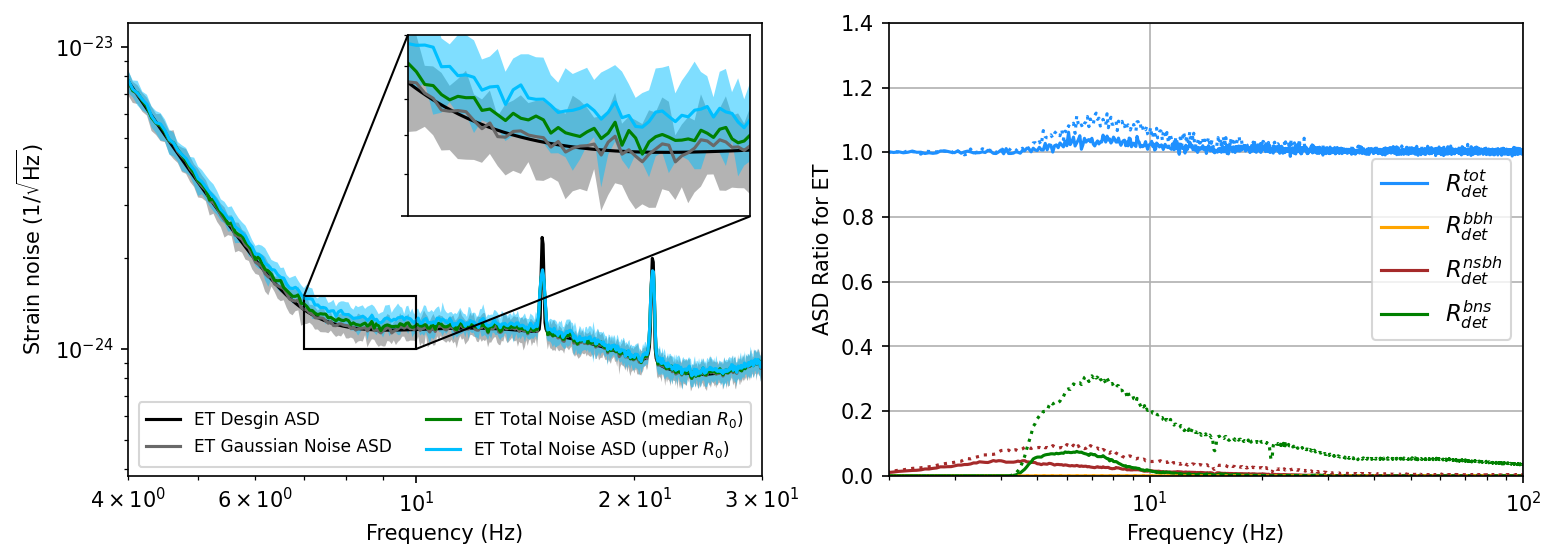

In [12]:
# plot these two together

f = plt.figure(figsize=(12,4), dpi=150)
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.loglog(asd_ETD[0], asd_ETD[1], color="black", label="ET Desgin ASD")
ax1.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="dimgray", label="ET Gaussian Noise ASD")
ax1.fill_between(psd_ETD_det[0], np.sqrt(onesigma_left_psd_ETD_det), np.sqrt(onesigma_right_psd_ETD_det), alpha=.5, linewidth=0, color="dimgray")
ax1.loglog(psd_ETD_total_median[0], np.sqrt(mean_psd_ETD_total_median), color="green", label=r"ET Total Noise ASD (median $R_{0}$)")
ax1.loglog(psd_ETD_total_upper[0], np.sqrt(mean_psd_ETD_total_upper), color="deepskyblue", label=r"ET Total Noise ASD (upper $R_{0}$)")
ax1.fill_between(psd_ETD_total_upper[0], np.sqrt(onesigma_left_psd_ETD_total_upper), np.sqrt(onesigma_right_psd_ETD_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

ax1.set_xlim(4, 30)
ax1.set_ylim(3.8*10**(-25), 1.2*10**(-23))
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
ax1.legend(loc="lower center", fontsize=8.2, ncol=2)

axins = inset_axes(ax1, width="60%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.425, 0.55, 0.9, 1),
                   bbox_transform=ax1.transAxes)

axins.loglog(asd_ETD[0], asd_ETD[1], color="black")
axins.loglog(psd_ETD_det[0], np.sqrt(mean_psd_ETD_det), color="dimgray")
axins.fill_between(psd_ETD_det[0], np.sqrt(onesigma_left_psd_ETD_det), np.sqrt(onesigma_right_psd_ETD_det), alpha=.5, linewidth=0, color="dimgray")
axins.loglog(psd_ETD_total_median[0], np.sqrt(mean_psd_ETD_total_median), color="green")
axins.loglog(psd_ETD_total_upper[0], np.sqrt(mean_psd_ETD_total_upper), color="deepskyblue")
axins.fill_between(psd_ETD_total_upper[0], np.sqrt(onesigma_left_psd_ETD_total_upper), np.sqrt(onesigma_right_psd_ETD_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

x1, x2, y1, y2 = 7, 10, 1.0*10**(-24), 1.5*10**(-24)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(which='both', bottom=False, labelbottom=False, labelleft=False)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec='k', lw=1)
ax1.indicate_inset_zoom(axins, edgecolor="black")

ax2.semilogx(psd_ETD_det[0], ratio_tot_guassian_median, color='dodgerblue', label=r"$R_{det}^{tot}$")
ax2.semilogx(psd_ETD_det[0], ratio_bbh_guassian_median, color='orange', label=r"$R_{det}^{bbh}$")
ax2.semilogx(psd_ETD_det[0], ratio_nsbh_guassian_median, color='brown', label=r"$R_{det}^{nsbh}$")
ax2.semilogx(psd_ETD_det[0], ratio_bns_guassian_median, color='green', label=r"$R_{det}^{bns}$")

ax2.semilogx(psd_ETD_det[0], ratio_tot_guassian_upper, color='dodgerblue', linestyle='dotted')
ax2.semilogx(psd_ETD_det[0], ratio_bbh_guassian_upper, color='orange', linestyle='dotted')
ax2.semilogx(psd_ETD_det[0], ratio_nsbh_guassian_upper, color='brown', linestyle='dotted')
ax2.semilogx(psd_ETD_det[0], ratio_bns_guassian_upper, color='green', linestyle='dotted')

ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("ASD Ratio for ET")
ax2.set_xlim(2, 100)
ax2.set_ylim(0, 1.4)
ax2.legend(loc='center right', fontsize=11)
ax2.grid()
f.savefig('asd_bias_and_ratio_ETD.pdf', dpi=500)
f.show()